In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import math
import numpy as np

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

# Calculate Sharpe Funciton

$$ SharpeRatio = \frac{\mu -r_f }{\sigma} $$

N.B. For the below function I not taking out the risk free rate because all of the returns have already removed the risk free rate, thus they are already excess returns.  

In [ ]:
def calc_Sharpe(pnl,N=12):
    return np.sqrt(N) * pnl.mean() / pnl.std()

# Multiasset Value and Momentum 

Asness et al 2013 Value and Momentum Everywhere
Data available on AQR's webpage

In [12]:
data=pd.read_csv('AQR.csv',parse_dates=['DATE'], index_col=0)[['VAL','MOM']]

# Fama French (1993) Three Factor Model

* Market
* SMB (Small minus Big)
* HML (High minus Low)

Available on Kenneth French's Dartmouth webpage

In [13]:
data=data.join(pd.read_csv('FF.csv',parse_dates=['Date'],index_col=0).resample(rule='m',how='sum')/100.)[['VAL', 'MOM', 'Mkt-RF', 'SMB', 'HML']].dropna()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


# 1/N Portoflio

$$ \frac{1}{N} \sum r_i $$

In [181]:
result=pd.DataFrame()
result['1/N']=data.mean(axis=1)

# 1/N Volatility scaled 

For each market returns are scaled by:
$$ \frac{r_t *volatilityTarget}{\sigma_{t-1}} $$


In [182]:
vol_target=.10
result['1/N Vol Scaled']=((data*vol_target)/(pd.ewmstd(data,24)*math.sqrt(12)).shift()).mean(axis=1)


/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,com=24).std(bias=False)
  


# Min Var portoflio

 $$ \max_{x_t} \left [ \omega' \mu - \frac{\gamma}{2}\omega' \Sigma \omega \right ] $$
 
 Solving for the first order condition (FOC), we get:
 
 $$ \omega = \frac{1}{\gamma} \Sigma^{-1} \mu $$

In [248]:
gamma=.02
sigma=data.cov().values
mu=data.mean().values
inverse = np.linalg.inv(sigma)
w=pd.Series(inverse.dot(mu),index=data.mean().index)*gamma

In [249]:
result['Ex-post Markowitz'] =(w*data).sum(axis=1)

# Ex-ante Markowitz

Window for the last three years to calculate weights for the next year

 $$ \max_{x_t} \left [ \omega' \hat{\mu_t}- \frac{\gamma}{2}\omega' \hat{\Sigma}_t \omega \right ] $$

In [185]:
s=pd.Series()
for y in range(1975,2017,1):
    w=minvar(data[str(y-3):str(y)])
    s=s.append((data[str(y+1)]*w).sum(axis=1))
result['Rolling 3 year Markowitz']=s
    

# Final Results

In [198]:
(result.std()*math.sqrt(12)).round(2)

1/N                         0.04
1/N Vol Scaled              0.04
Ex-post Markowitz           0.03
Rolling 3 year Markowitz    0.03
dtype: float64

In [251]:
calc_Sharpe(result).round(2)

1/N                         1.04
1/N Vol Scaled              1.05
Ex-post Markowitz           1.40
Rolling 3 year Markowitz    1.52
dtype: float64

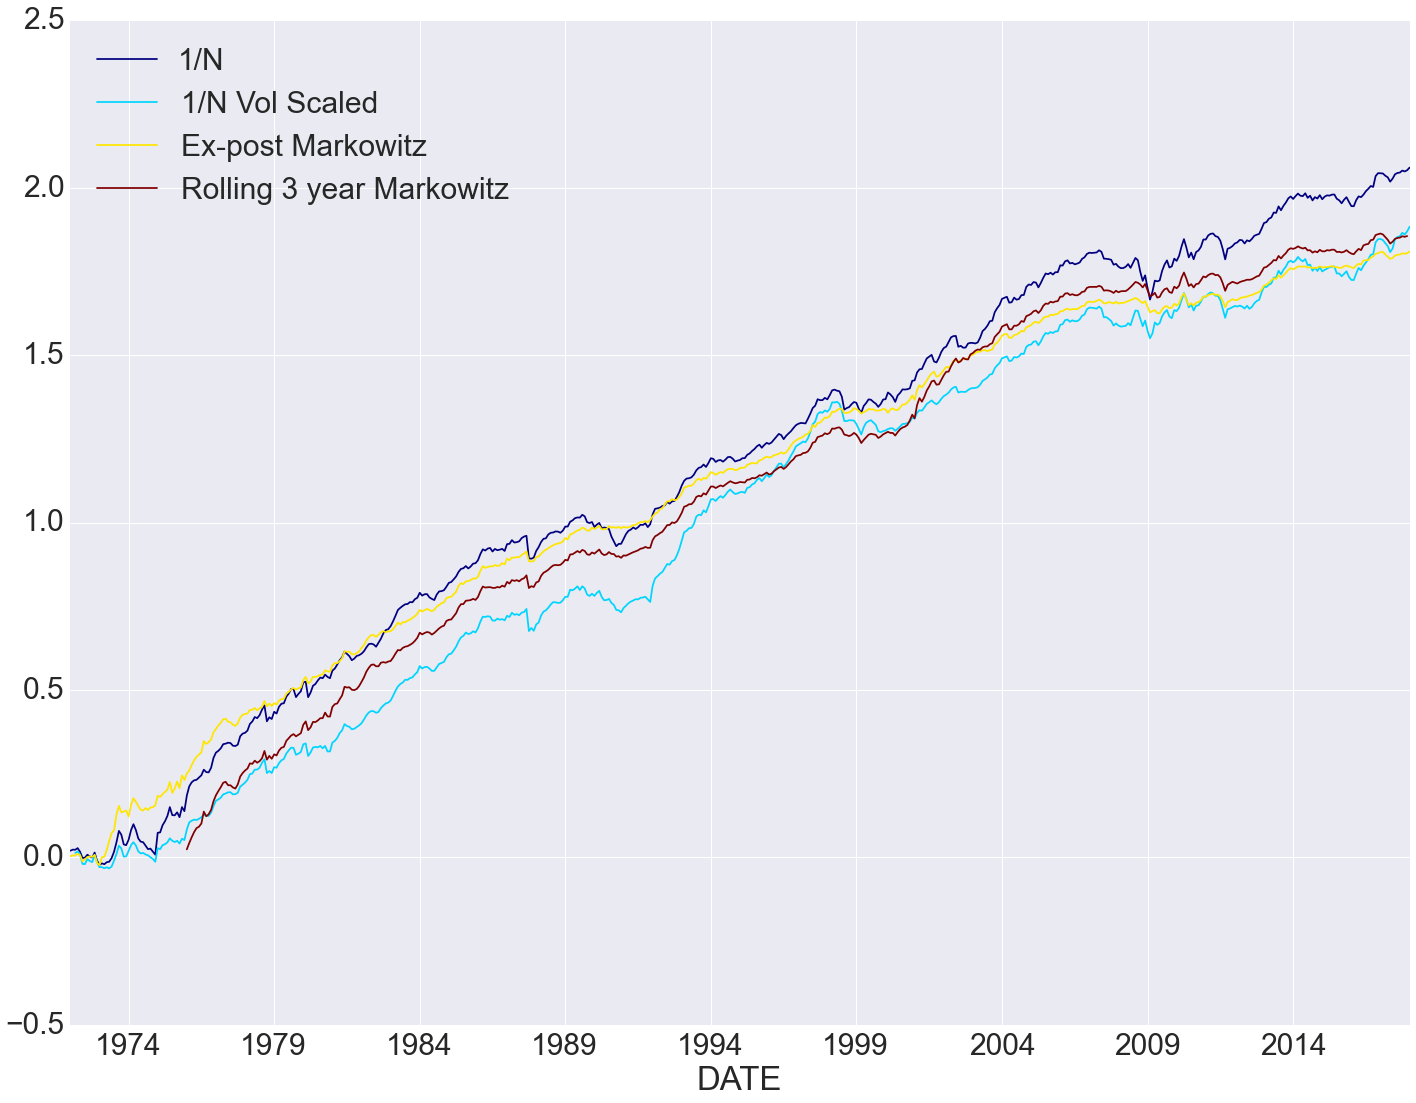

In [250]:
result.cumsum().plot(colormap='jet')

# Things to add / fix

* Markowitz needs some help
* Min var
* Max diversification
* Risk parity

In [ ]:
cols=prices.columns
prices=prices.dropna().values
cov=data.cov().values




vu=np.array(cov.shape[1]*[1], float)
num=np.dot(np.linalg.inv(cov),vu)
den=np.dot(vu,num)
return pd.Series(num/den,index=cols)

In [199]:
np.array(cov.shape[1]*[1], float)

array([ 1.,  1.,  1.,  1.,  1.])

In [252]:
gamma=.04
cov=data.cov().values
mu=data.mean().values
inverse = np.linalg.inv(cov)
w=pd.Series(inverse.dot(mu),index=data.mean().index)*gamma

In [263]:
w_min_vol=pd.Series(inverse.dot(mu/mu),index=data.mean().index)*gamma

In [264]:
calc_Sharpe((w_min_vol*data).sum(axis=1))

1.3338256608173524

In [265]:
w_min_vol


VAL       127.843975
MOM       139.986171
Mkt-RF     32.408845
SMB        44.849273
HML        52.952946
dtype: float64

In [262]:
w

VAL       0.511765
MOM       0.608123
Mkt-RF    0.192892
SMB       0.020342
HML       0.205556
dtype: float64